In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from nltk.stem.porter import PorterStemmer
from collections import Counter
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


### We dont know true cluster labels. In this case we can use [Silhouette Coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for calculating score of clusterization. The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters.

In [2]:
COLUMNS_TO_DROP = ['year', 'n_citation', 'references', 'authors']
NUM_PARTS = 3
RANDOM_STATE = 42
REDUCED_DIMENSION = 100
NUM_CLUSTERS = 50

def plot_clusters(cluster_ids, cluster_sizes, cluster_names):
    plt.figure(figsize=(18, 7))
    plt.bar(cluster_ids, cluster_sizes)
    plt.xlabel('Cluster id')
    plt.xticks(range(NUM_CLUSTERS))
    plt.title('Cluster sizes')
    ax = plt.gca()
    for bar, word in zip(ax.patches, cluster_names):
        ax.text(bar.get_x() + bar.get_width() / 4, bar.get_y() + bar.get_height()*1.05, word, rotation='vertical', color = 'black', va = 'bottom', fontsize=10) 
    plt.show()

def get_score(X, cluster_labels, sample_size=10000):
    return silhouette_score(X, pipe['kmeans'].labels_, sample_size=sample_size, random_state=RANDOM_STATE)

def get_text_data(file_path):
    data = pd.read_json(file_path, dtype={'title': 'string', 'abstract': 'string'}).drop(COLUMNS_TO_DROP, axis=1)
    data['keywords'] = data['keywords'].apply(lambda row: ' '.join(row)).astype('string')
    data['fos'] = data['fos'].apply(lambda row: ' '.join(row)).astype('string')
    data['venue'] = data['venue'].apply(lambda row: row.get('name_d', '')).astype('string')
    
    data['text'] = data[['keywords', 'fos', 'abstract']].apply(lambda row: ' '.join(row.astype(str)), axis=1).astype('string')
    data.drop(['title', 'abstract', 'venue'], axis=1, inplace=True)
    return data

### Time consuming cell below: 3 parts are loaded, transformed and concatenated together.

In [3]:
articles = pd.concat(get_text_data(f'data/part_{i+1}_clean.json') for i in range(NUM_PARTS))
articles.reset_index(drop=True, inplace=True)
# articles = pd.read_json('articles.json')

articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1084405 entries, 0 to 1084404
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   _id       1084405 non-null  object
 1   keywords  1084405 non-null  string
 2   fos       1084405 non-null  string
 3   text      1084405 non-null  string
dtypes: object(1), string(3)
memory usage: 33.1+ MB


In [4]:
articles

,_id,keywords,fos,text
0,53e99784b7602d9701f3e151,handwriting recognition prototypes image segme...,Intelligent character recognition Pattern reco...,handwriting recognition prototypes image segme...
1,53e99784b7602d9701f3e15d,sequential circuits statistical distributions ...,Delay calculation Timing failure Monte Carlo m...,sequential circuits statistical distributions ...
2,53e99784b7602d9701f3f411,Internet hypermedia markup languages informati...,XML Base World Wide Web XML framework XML Encr...,Internet hypermedia markup languages informati...
3,53e99792b7602d9701f5af1a,cognition multi-agent systems ubiquitous compu...,Syma Computer science Symbiotic computing Mult...,cognition multi-agent systems ubiquitous compu...
4,53e99792b7602d9701f5b0a5,balanced scorecard,Lease Computer science Balanced scorecard Busi...,balanced scorecard Lease Computer science Bala...
...,...,...,...,...
1084400,6052d1c79e795e222b127d58,Sketch Information retrieval Solid modeling Ta...,Training set 3d model Task analysis Informatio...,Sketch Information retrieval Solid modeling Ta...
1084401,6052fa249e795e222b13be15,Hash function Random oracle Discrete mathemati...,Discrete mathematics Time space Computer scien...,Hash function Random oracle Discrete mathemati...
1084402,6054328e9e795e40330e1fa2,Stereopsis Computer vision Daytime Artificial ...,Network on Computer vision Computer science St...,Stereopsis Computer vision Daytime Artificial ...
1084403,605828249e795e357b471758,Search engine Data as a service Autonomous sys...,Search engine Situation awareness Computer sci...,Search engine Data as a service Autonomous sys...


### Applying [Porter stemming](https://www.nltk.org/api/nltk.stem.porter.html) to normalize text data

In [5]:
porter = PorterStemmer()

In [6]:
%%time
articles = articles.parallel_applymap(porter.stem)

CPU times: total: 12.1 s
Wall time: 30.4 s


In [7]:
articles

,_id,keywords,fos,text
0,53e99784b7602d9701f3e151,handwriting recognition prototypes image segme...,intelligent character recognition pattern reco...,handwriting recognition prototypes image segme...
1,53e99784b7602d9701f3e15d,sequential circuits statistical distributions ...,delay calculation timing failure monte carlo m...,sequential circuits statistical distributions ...
2,53e99784b7602d9701f3f411,internet hypermedia markup languages informati...,xml base world wide web xml framework xml encr...,internet hypermedia markup languages informati...
3,53e99792b7602d9701f5af1a,cognition multi-agent systems ubiquitous compu...,syma computer science symbiotic computing mult...,cognition multi-agent systems ubiquitous compu...
4,53e99792b7602d9701f5b0a5,balanced scorecard,lease computer science balanced scorecard busi...,balanced scorecard lease computer science bala...
...,...,...,...,...
1084400,6052d1c79e795e222b127d58,sketch information retrieval solid modeling ta...,training set 3d model task analysis informatio...,sketch information retrieval solid modeling ta...
1084401,6052fa249e795e222b13be15,hash function random oracle discrete mathemati...,discrete mathematics time space computer scien...,hash function random oracle discrete mathemati...
1084402,6054328e9e795e40330e1fa2,stereopsis computer vision daytime artificial ...,network on computer vision computer science st...,stereopsis computer vision daytime artificial ...
1084403,605828249e795e357b471758,search engine data as a service autonomous sys...,search engine situation awareness computer sci...,search engine data as a service autonomous sys...


In [8]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df=10, stop_words='english')
svd = TruncatedSVD(n_components=REDUCED_DIMENSION, random_state=RANDOM_STATE)
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=RANDOM_STATE)

pipe = Pipeline([
    ('tfidf', vectorizer),
    ('svd', svd),
    ('kmeans', kmeans)
])

In [9]:
%%time
pipe.fit(articles.text)

cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)

articles_compressed = pipe[:-1].transform(articles.text)
print(articles_compressed.shape)

(1084405, 100)
CPU times: total: 32min 16s
Wall time: 5min 50s


In [10]:
print('Score:', get_score(articles_compressed, kmeans.labels_))  #n_com=100 0.06735451976061607

Score: 0.07780591489732268


### Cluster names based on tfidf score of cluster centers

In [11]:
original_space_centroids = svd.inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
cluster_names = terms[order_centroids[:, 0]]

topK = 5
for i in range(NUM_CLUSTERS):
    print(f'Cluster {i}: ', end='')
    print(' '.join(terms[order_centroids[i, :topK]]))

Cluster 0: decision support tree making process
Cluster 1: parallel memory computing architecture distributed
Cluster 2: web world wide semantic service
Cluster 3: information retrieval search web technology
Cluster 4: sensor wireless network networks energy
Cluster 5: robot mobile control robots kinematics
Cluster 6: mathematics discrete matrix algorithm linear
Cluster 7: fuzzy set logic control neuro
Cluster 8: control theory engineering nonlinear systems
Cluster 9: cache memory performance peer chip
Cluster 10: routing protocol network link wireless
Cluster 11: recognition face pattern facial artificial
Cluster 12: mobile computing device network communication
Cluster 13: filter kalman filters adaptive signal
Cluster 14: game theory games equilibrium design
Cluster 15: query search retrieval database language
Cluster 16: graph mathematics combinatorics graphs discrete
Cluster 17: network traffic wireless packet networks
Cluster 18: fault tolerance tolerant test detection
Cluster 19:

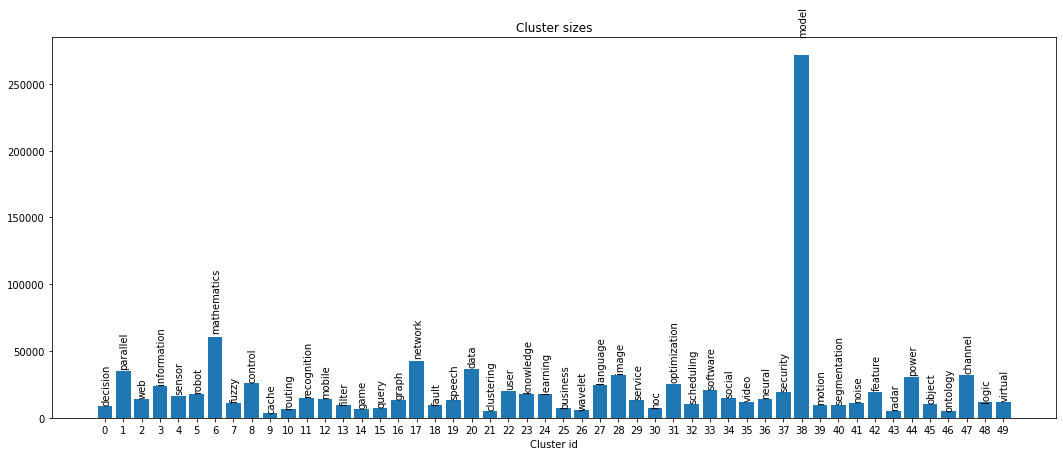

In [12]:
plot_clusters(cluster_ids, cluster_sizes, cluster_names)

### Cluster names based on top words from `keyrowds` + `fos`

In [13]:
cluster_names_counter = []

for cluster_id in range(NUM_CLUSTERS):
    cluster = articles.loc[np.argwhere(kmeans.labels_ == cluster_id).flatten()]
    c = Counter(' '.join((cluster.keywords + ' ' + cluster.fos).values).split())
    print(f'Cluster {cluster_id}: ', end='')
    top_words = c.most_common(topK)
    print(' '.join(pair[0] for pair in top_words))
    cluster_names_counter.append(top_words[0][0])

Cluster 0: decision system support computer science
Cluster 1: computer parallel memory computing science
Cluster 2: web computer science semantic world
Cluster 3: information retrieval computer science system
Cluster 4: sensor wireless network computer networks
Cluster 5: robot control mobile computer engineering
Cluster 6: mathematics algorithm discrete matrix mathemat
Cluster 7: fuzzy set control system logic
Cluster 8: control system theory engineering systems
Cluster 9: cache computer memory science system
Cluster 10: routing protocol network computer wireless
Cluster 11: recognition computer face artificial pattern
Cluster 12: mobile computer computing network science
Cluster 13: filter kalman filters computer adaptive
Cluster 14: game computer science design theory
Cluster 15: query data computer science search
Cluster 16: graph mathematics computer science combinatorics
Cluster 17: network computer science wireless traffic
Cluster 18: fault computer system tolerance science
Clu

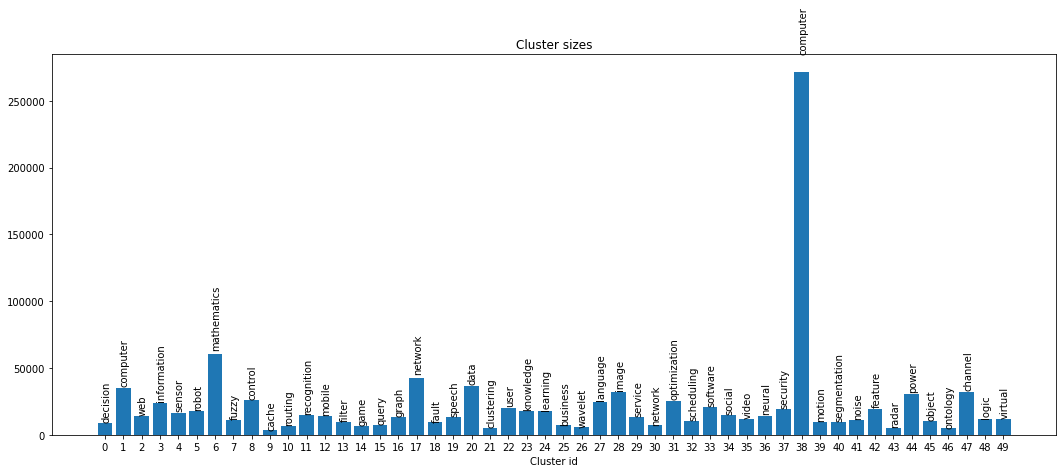

In [14]:
plot_clusters(cluster_ids, cluster_sizes, cluster_names_counter)